In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split, WeightedRandomSampler
import cv2
import mediapipe as mp
import pandas as pd
import matplotlib.pyplot as plt
import csv

In [3]:
class EnhancedGestureLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, bidirectional=True):
        """
        Enhanced LSTM model for ISL recognition with support for bidirectional processing
        and additional features.
        
        :param input_size: Number of features per frame
        :param hidden_size: Number of hidden units in the LSTM layers
        :param num_layers: Number of LSTM layers
        :param num_classes: Number of gesture classes
        :param bidirectional: Whether to use bidirectional LSTM
        """
        super(EnhancedGestureLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.num_directions = 2 if bidirectional else 1
        
        # Main LSTM for temporal processing
        self.lstm = nn.LSTM(
            input_size, 
            hidden_size, 
            num_layers, 
            batch_first=True,
            bidirectional=bidirectional,
            dropout=0.2 if num_layers > 1 else 0
        )
        
        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Linear(hidden_size * self.num_directions, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )
        
        # Classification layers
        self.fc1 = nn.Linear(hidden_size * self.num_directions, hidden_size)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        """
        Forward pass with attention mechanism
        :param x: Input tensor of shape (batch_size, sequence_length, input_size)
        :return: Logits for each class
        """
        # LSTM layer
        lstm_out, _ = self.lstm(x)  # Shape: (batch_size, seq_len, hidden_size*num_directions)
        
        # Attention mechanism
        attn_weights = self.attention(lstm_out)  # Shape: (batch_size, seq_len, 1)
        attn_weights = torch.softmax(attn_weights, dim=1)  # Apply softmax across sequence dimension
        
        # Apply attention weights
        context = torch.sum(lstm_out * attn_weights, dim=1)  # Shape: (batch_size, hidden_size*num_directions)
        
        # Classification
        out = self.fc1(context)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        
        return out

In [6]:
class GestureDataset(Dataset):
    def __init__(self, data_dir):
        """
        Initializes the dataset by scanning the provided directory for .npy files.
        Assumes filenames are formatted as "gestureLabel_index.npy".
        :param data_dir: Directory containing the processed .npy files.
        """
        self.file_paths = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(".npy")]
        # Create a mapping from gesture labels to numeric indices.
        label_set = set()
        for f in self.file_paths:
            label = os.path.basename(f).split("_")[0]
            label_set.add(label)
        self.label2idx = {label: idx for idx, label in enumerate(sorted(label_set))}
    
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        """
        Loads a keypoint sequence and its label for a given index.
        :param idx: Index of the sample.
        :return: A tuple (sequence, label) where sequence is a tensor of shape (sequence_length, num_features)
                 and label is a tensor (numeric label).
        """
        file_path = self.file_paths[idx]
        sequence = np.load(file_path)  # Expected shape: (sequence_length, num_features)
        sequence = torch.tensor(sequence, dtype=torch.float32)
        label_str = os.path.basename(file_path).split("_")[0]
        label = self.label2idx[label_str]
        label = torch.tensor(label, dtype=torch.long)
        return sequence, label


In [13]:
def compute_class_weights(dataset):
    """Calculate weights for each class to handle class imbalance"""
    # Get all labels safely
    labels = []
    for i in range(len(dataset)):
        try:
            label = dataset[i][1].item() if isinstance(dataset[i][1], torch.Tensor) else dataset[i][1]
            labels.append(label)
        except Exception as e:
            print(f"Error accessing sample {i}: {e}")
    
    # Compute class counts
    unique_labels = set(labels)
    class_counts = {}
    for label in unique_labels:
        class_counts[label] = labels.count(label)
    
    # Create weights (inverse frequency)
    weights = []
    for i in range(len(dataset)):
        try:
            label = dataset[i][1].item() if isinstance(dataset[i][1], torch.Tensor) else dataset[i][1]
            weight = 1.0 / class_counts[label]
            weights.append(weight)
        except Exception as e:
            print(f"Error computing weight for sample {i}: {e}")
            weights.append(1.0)  # Default weight
    
    # Convert to tensor
    return torch.tensor(weights, dtype=torch.float)

In [14]:
def train_enhanced_model(data_dir, num_epochs=50, batch_size=16, learning_rate=0.001, model_version="enhanced"):
    """
    Enhanced training function for ISL recognition with dynamic feature detection
    Fixed to handle sampling issues
    """
    # Create the dataset and automatically detect input size
    dataset = GestureDataset(data_dir)
    
    # Split dataset into training and validation sets (80% train, 20% validation)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    
    # Use standard DataLoaders without weighted sampling first
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Try to get sample data safely
    sample = None
    for i in range(min(10, len(dataset))):
        try:
            sample = dataset[i]
            break
        except Exception as e:
            print(f"Error accessing sample {i}: {e}")
    
    if sample is None:
        raise ValueError("Could not access any sample from the dataset")
        
    sample_seq, _ = sample
    input_size = sample_seq.shape[1]
    num_classes = len(dataset.label2idx)
    
    print(f"Detected input size: {input_size}")
    print(f"Number of gesture classes: {num_classes}")
    
    # Initialize the enhanced LSTM model
    model = EnhancedGestureLSTM(
        input_size=input_size, 
        hidden_size=128, 
        num_layers=2, 
        num_classes=num_classes,
        bidirectional=True
    )
    
    # Use GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # Use AdamW optimizer with weight decay
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    
    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5, verbose=True
    )
    
    # Loss function with label smoothing for better generalization
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    
    print(f"Training on {device} with {len(train_dataset)} training samples and {len(val_dataset)} validation samples.")
    
    best_val_loss = float('inf')
    
    # Prepare CSV logging directory
    os.makedirs(os.path.join("..", "logs"), exist_ok=True)
    log_file = os.path.join("..", "logs", f"training_log_{model_version}.csv")
    with open(log_file, mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["epoch", "train_loss", "train_acc", "val_loss", "val_acc"])
    
    # Training loop
    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        # Training phase
        for sequences, labels in train_loader:
            sequences, labels = sequences.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            loss.backward()
            
            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            running_loss += loss.item() * sequences.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = running_loss / total
        train_acc = (correct / total) * 100
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        
        with torch.no_grad():
            for sequences, labels in val_loader:
                sequences, labels = sequences.to(device), labels.to(device)
                outputs = model(sequences)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * sequences.size(0)
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        
        val_loss /= total_val
        val_acc = (correct_val / total_val) * 100
        
        # Update learning rate based on validation loss
        scheduler.step(val_loss)
        
        print(f"Epoch [{epoch}/{num_epochs}] - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        
        # Append metrics to CSV log
        with open(log_file, mode="a", newline="") as file:
            writer = csv.writer(file)
            writer.writerow([epoch, train_loss, train_acc, val_loss, val_acc])
        
        # Save the model checkpoint if validation loss improves
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            os.makedirs(os.path.join("..", "models"), exist_ok=True)
            checkpoint_path = os.path.join("..", "models", f"gesture_model_{model_version}.pt")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'val_loss': val_loss,
                'val_acc': val_acc,
                'input_size': input_size,
                'num_classes': num_classes,
                'label_map': dataset.label2idx
            }, checkpoint_path)
            print(f"Model improved. Saved checkpoint to {checkpoint_path}")
    
    print("Training complete.")

In [15]:
DATA_DIR = os.path.join("..", "data", "processed")
train_enhanced_model(DATA_DIR)

Detected input size: 342
Number of gesture classes: 7
Training on cuda with 1176 training samples and 294 validation samples.
Epoch [1/50] - Train Loss: 1.3148, Train Acc: 57.14% | Val Loss: 0.9010, Val Acc: 76.87%
Model improved. Saved checkpoint to ..\models\gesture_model_enhanced.pt
Epoch [2/50] - Train Loss: 0.8529, Train Acc: 82.06% | Val Loss: 0.7186, Val Acc: 87.41%
Model improved. Saved checkpoint to ..\models\gesture_model_enhanced.pt
Epoch [3/50] - Train Loss: 0.6838, Train Acc: 91.84% | Val Loss: 0.5826, Val Acc: 94.22%
Model improved. Saved checkpoint to ..\models\gesture_model_enhanced.pt
Epoch [4/50] - Train Loss: 0.6733, Train Acc: 92.18% | Val Loss: 0.5961, Val Acc: 94.22%
Epoch [5/50] - Train Loss: 0.6181, Train Acc: 93.62% | Val Loss: 0.6644, Val Acc: 90.82%
Epoch [6/50] - Train Loss: 0.5691, Train Acc: 96.09% | Val Loss: 0.5827, Val Acc: 93.20%
Epoch [7/50] - Train Loss: 0.5659, Train Acc: 96.77% | Val Loss: 0.5387, Val Acc: 96.26%
Model improved. Saved checkpoint to

In [16]:
log_file = os.path.join("..", "logs", "training_log_enhanced.csv")
df = pd.read_csv(log_file)

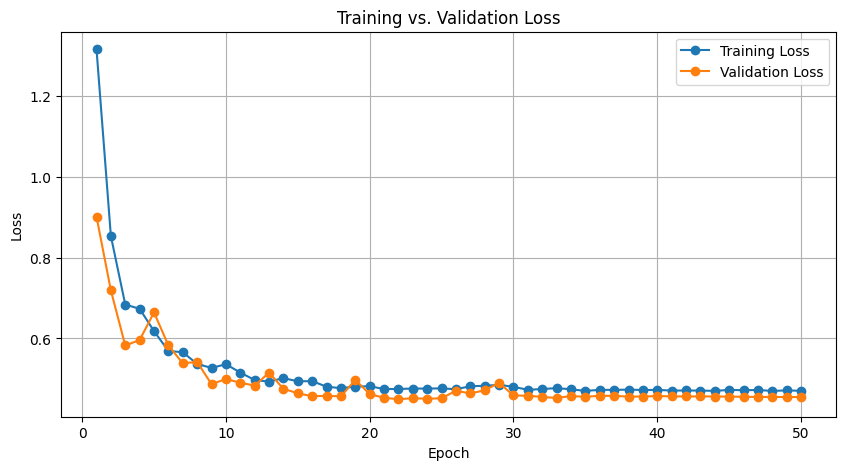

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(df['epoch'], df['train_loss'], label='Training Loss', marker='o')
plt.plot(df['epoch'], df['val_loss'], label='Validation Loss', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join("..","graphs","loss_curve.png"))
plt.show()

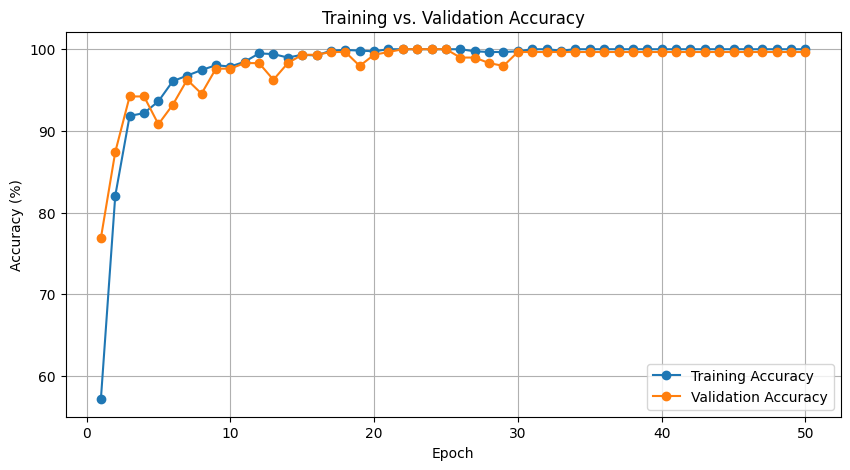

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(df['epoch'], df['train_acc'], label='Training Accuracy', marker='o')
plt.plot(df['epoch'], df['val_acc'], label='Validation Accuracy', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training vs. Validation Accuracy")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join("..","graphs","accuracy_curve.png"))
plt.show()

In [13]:
def extract_enhanced_keypoints(frame, holistic):
    """Extract enhanced keypoints with MediaPipe Holistic"""
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = holistic.process(frame_rgb)
    
    features = []
    
    # Left hand landmarks
    left_hand = []
    if results.left_hand_landmarks:
        for lm in results.left_hand_landmarks.landmark:
            left_hand.extend([lm.x, lm.y, lm.z])
    else:
        left_hand = [0] * (21 * 3)
        
    # Right hand landmarks
    right_hand = []
    if results.right_hand_landmarks:
        for lm in results.right_hand_landmarks.landmark:
            right_hand.extend([lm.x, lm.y, lm.z])
    else:
        right_hand = [0] * (21 * 3)
    
    # Extract key face landmarks for hand-face interactions
    face = []
    if results.face_landmarks:
        # Extract key points from face (lips, nose, eyes)
        key_face_points = [0, 13, 14, 17, 37, 267, 291, 314, 346, 375]
        for idx in key_face_points:
            lm = results.face_landmarks.landmark[idx]
            face.extend([lm.x, lm.y, lm.z])
    else:
        face = [0] * (10 * 3)
    
    # Combine features
    features.extend(left_hand)
    features.extend(right_hand)
    features.extend(face)
    
    return np.array(features), results

In [4]:
def run_real_time_prediction():
    mp_holistic = mp.solutions.holistic
    mp_drawing = mp.solutions.drawing_utils
    
    # Load model and metadata
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    checkpoint = torch.load(os.path.join("..", "models", "gesture_model_enhanced.pt"), 
                           map_location=device)
    
    # Get expected input size from the saved model
    expected_input_size = checkpoint['input_size']
    print(f"Model expects input size: {expected_input_size}")
    
    # Create model with correct architecture
    model = EnhancedGestureLSTM(
        input_size=expected_input_size,
        hidden_size=128,
        num_layers=2,
        num_classes=checkpoint['num_classes'],
        bidirectional=True
    )
    
    # Load weights
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    
    # Setup for real-time capture
    cap = cv2.VideoCapture(0)
    sequence = []
    sequence_length = 30
    
    # Create label mapping (reverse of dataset.label2idx)
    label_map = {v: k for k, v in checkpoint['label_map'].items()}
    print(f"Loaded {len(label_map)} gesture classes: {', '.join(label_map.values())}")
    
    # Track previous features for velocity calculation
    prev_features = None
    
    with mp_holistic.Holistic(
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5) as holistic:
        
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            
            # Extract features
            features, results = extract_enhanced_keypoints(frame, holistic)
            
            # Calculate velocity features
            if prev_features is not None:
                velocity = features - prev_features
                features_with_vel = np.concatenate([features, velocity])
            else:
                # For first frame, use zeros for velocity
                velocity = np.zeros_like(features)
                features_with_vel = np.concatenate([features, velocity])
            
            # Store current features for next iteration
            prev_features = features
            
            # Ensure we have the right input size - pad or truncate as needed
            if len(features_with_vel) < expected_input_size:
                # Pad with zeros if we have fewer features than expected
                padding = np.zeros(expected_input_size - len(features_with_vel))
                features_with_vel = np.concatenate([features_with_vel, padding])
            elif len(features_with_vel) > expected_input_size:
                # Truncate if we have more features than expected
                features_with_vel = features_with_vel[:expected_input_size]
                
            # Now add to sequence
            if features_with_vel is not None:
                sequence.append(features_with_vel)
                if len(sequence) > sequence_length:
                    sequence.pop(0)  # Remove oldest frame
                
                # Make prediction if we have enough frames
                if len(sequence) == sequence_length:
                    input_seq = np.array(sequence)
                    input_seq = torch.tensor(input_seq, dtype=torch.float32).unsqueeze(0).to(device)
                    
                    with torch.no_grad():
                        output = model(input_seq)
                        probabilities = torch.softmax(output, dim=1)[0]
                        predicted_idx = torch.argmax(probabilities).item()
                        confidence = probabilities[predicted_idx].item()
                        gesture_name = label_map[predicted_idx]
                        
                    # Display prediction with confidence
                    cv2.putText(frame, f"{gesture_name} ({confidence:.2f})", 
                                (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, 
                                (0, 255, 0), 2, cv2.LINE_AA)
            
            # Draw landmarks
            if results.right_hand_landmarks:
                mp_drawing.draw_landmarks(frame, results.right_hand_landmarks, 
                                         mp_holistic.HAND_CONNECTIONS)
            if results.left_hand_landmarks:
                mp_drawing.draw_landmarks(frame, results.left_hand_landmarks, 
                                         mp_holistic.HAND_CONNECTIONS)
            if results.face_landmarks:
                mp_drawing.draw_landmarks(frame, results.face_landmarks, 
                                         mp_holistic.FACEMESH_CONTOURS,
                                         landmark_drawing_spec=None)
            
            cv2.imshow('Enhanced ISL Recognition', frame)
            if cv2.waitKey(5) & 0xFF == 27:  # ESC to quit
                break
                
    cap.release()
    cv2.destroyAllWindows()

In [8]:
run_real_time_prediction()

Model expects input size: 342
Loaded 7 gesture classes: bye, hello, namaste, practice, sorry, thankyou, welcome


In [3]:
class EnhancedGestureLSTMv2(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=2, num_classes=7, 
                 dropout=0.5, bidirectional=True):
        """
        Advanced model for ISL recognition with:
        - Hierarchical feature extraction
        - Temporal ConvNets
        - Residual connections
        - Multi-level attention
        
        Args:
            input_size: Number of input features
            hidden_size: LSTM hidden dimension
            num_layers: Number of LSTM layers
            num_classes: Number of output classes
            dropout: Dropout probability
            bidirectional: Whether to use bidirectional LSTM
        """
        super(EnhancedGestureLSTMv2, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_directions = 2 if bidirectional else 1
        
        # Feature extraction layers
        self.feature_extractor = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.LayerNorm(hidden_size),
            nn.GELU(),
            nn.Dropout(0.3),
        )
        
        # 1D Temporal Convolution to capture local patterns
        self.temporal_conv = nn.Sequential(
            nn.Conv1d(hidden_size, hidden_size, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Conv1d(hidden_size, hidden_size, kernel_size=5, padding=2),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
        )
        
        # Bidirectional LSTM with residual connections
        self.lstm = nn.LSTM(
            input_size=hidden_size, 
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Multi-head self-attention
        self.self_attn = nn.MultiheadAttention(
            embed_dim=hidden_size * self.num_directions,
            num_heads=8,
            dropout=0.1,
            batch_first=True
        )
        
        # Position-wise attention
        self.pos_attention = nn.Sequential(
            nn.Linear(hidden_size * self.num_directions, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )
        
        # Feature fusion layers
        self.fusion = nn.Sequential(
            nn.Linear(hidden_size * self.num_directions * 2, hidden_size),
            nn.LayerNorm(hidden_size),
            nn.GELU(),
            nn.Dropout(dropout)
        )
        
        # Output layers
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.LayerNorm(hidden_size // 2),
            nn.GELU(),
            nn.Dropout(dropout/2),
            nn.Linear(hidden_size // 2, num_classes)
        )
        
        # Special learning focus for difficult gestures
        # This auxiliary classifier will specifically learn to distinguish
        # between similar gestures
        self.gesture_discriminator = nn.Sequential(
            nn.Linear(hidden_size * self.num_directions, hidden_size),
            nn.LayerNorm(hidden_size),
            nn.GELU(),
            nn.Linear(hidden_size, num_classes)
        )
        
    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        
        # Initial feature extraction
        features = self.feature_extractor(x)  # [batch, seq_len, hidden_size]
        
        # Apply temporal convolution
        # Reshape for Conv1d: [batch, channels, length]
        conv_in = features.permute(0, 2, 1)  
        conv_out = self.temporal_conv(conv_in)  
        # Reshape back: [batch, seq_len, hidden_size]
        conv_out = conv_out.permute(0, 2, 1)  
        
        # Residual connection
        features = features + conv_out
        
        # LSTM processing
        lstm_out, _ = self.lstm(features)  # [batch, seq_len, hidden_size*directions]
        
        # Self-attention mechanism
        attn_out, _ = self.self_attn(lstm_out, lstm_out, lstm_out)
        
        # Residual connection
        lstm_out = lstm_out + attn_out
        
        # Position-wise attention
        pos_weights = self.pos_attention(lstm_out)
        pos_weights = torch.softmax(pos_weights, dim=1)
        weighted_lstm = lstm_out * pos_weights
        
        # Two attention methods
        # 1. Global context vector from position attention
        context_vector = torch.sum(weighted_lstm, dim=1)  # [batch, hidden*directions]
        
        # 2. Max pooling across time for salient features
        max_pooled, _ = torch.max(lstm_out, dim=1)  # [batch, hidden*directions]
        
        # Concatenate different feature representations
        combined = torch.cat([context_vector, max_pooled], dim=1)
        
        # Feature fusion
        fused = self.fusion(combined)
        
        # Final classification
        output = self.classifier(fused)
        
        # Auxiliary output from original LSTM representation
        aux_output = self.gesture_discriminator(context_vector)
        
        return output, aux_output

In [4]:
def train_enhanced_model_v2(data_dir, num_epochs=80, batch_size=16, learning_rate=0.0005, 
                          model_version="enhanced_v2", focal_loss_gamma=2.0):
    """
    Training function for the EnhancedGestureLSTMv2 model
    Uses advanced training techniques like:
    - Focal Loss for handling class imbalance
    - Auxiliary loss for difficult gestures
    - Cosine learning rate scheduling
    - Mixed precision training
    """
    # Create dataset
    print("Loading dataset...")
    dataset = GestureDataset(data_dir)
    
    # Split dataset
    train_size = int(0.75 * len(dataset))  # Use more data for training
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    # Get input dimensions
    sample = None
    for i in range(min(10, len(dataset))):
        try:
            sample = dataset[i]
            break
        except:
            continue
    
    if sample is None:
        raise ValueError("Could not access any sample from the dataset")
    
    sample_seq, _ = sample
    input_size = sample_seq.shape[1]
    num_classes = len(dataset.label2idx)
    
    print(f"Input size: {input_size}, Classes: {num_classes}")
    
    # Create the enhanced V2 model
    model = EnhancedGestureLSTMv2(
        input_size=input_size,
        hidden_size=128,
        num_layers=2,
        num_classes=num_classes,
        dropout=0.5,
        bidirectional=True
    )
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # Define Focal Loss for handling class imbalance
    class FocalLoss(nn.Module):
        def __init__(self, gamma=focal_loss_gamma, alpha=None, reduction='mean'):
            super(FocalLoss, self).__init__()
            self.gamma = gamma
            self.alpha = alpha
            self.reduction = reduction
            self.ce = nn.CrossEntropyLoss(reduction='none')
            
        def forward(self, input, target):
            ce_loss = self.ce(input, target)
            pt = torch.exp(-ce_loss)
            focal_loss = (1 - pt) ** self.gamma * ce_loss
            
            if self.reduction == 'mean':
                return focal_loss.mean()
            elif self.reduction == 'sum':
                return focal_loss.sum()
            return focal_loss
    
    # Use both Focal Loss and standard CrossEntropy
    criterion1 = FocalLoss(gamma=focal_loss_gamma)
    criterion2 = nn.CrossEntropyLoss(label_smoothing=0.1)
    
    # Optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    
    # Cosine annealing scheduler with warm restarts
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=10, T_mult=1, eta_min=learning_rate/20
    )
    
    # Mixed precision training
    scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None
    
    print(f"Training on {device} with {len(train_dataset)} training samples and {len(val_dataset)} validation samples.")
    
    best_val_loss = float('inf')
    
    # Prepare logging
    os.makedirs(os.path.join("..", "logs"), exist_ok=True)
    log_file = os.path.join("..", "logs", f"training_log_{model_version}.csv")
    with open(log_file, mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["epoch", "train_loss", "train_acc", "val_loss", "val_acc"])
    
    # Training loop
    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        # Training phase
        for sequences, labels in train_loader:
            sequences, labels = sequences.to(device), labels.to(device)
            optimizer.zero_grad()
            
            # Use mixed precision for faster training if available
            if scaler:
                with torch.cuda.amp.autocast():
                    outputs, aux_outputs = model(sequences)
                    # Main loss + auxiliary loss with lower weight
                    loss = criterion1(outputs, labels) + 0.3 * criterion2(aux_outputs, labels)
                
                # Scale gradients and optimize
                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs, aux_outputs = model(sequences)
                loss = criterion1(outputs, labels) + 0.3 * criterion2(aux_outputs, labels)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
            
            running_loss += loss.item() * sequences.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = running_loss / total
        train_acc = (correct / total) * 100
        
        # Update learning rate
        scheduler.step()
        current_lr = scheduler.get_last_lr()[0]
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        
        # Class-wise validation accuracy
        class_correct = [0] * num_classes
        class_total = [0] * num_classes
        
        with torch.no_grad():
            for sequences, labels in val_loader:
                sequences, labels = sequences.to(device), labels.to(device)
                outputs, aux_outputs = model(sequences)
                loss = criterion1(outputs, labels) + 0.3 * criterion2(aux_outputs, labels)
                val_loss += loss.item() * sequences.size(0)
                
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
                
                # Track per-class accuracy
                for i in range(labels.size(0)):
                    label = labels[i]
                    class_correct[label] += (predicted[i] == label).item()
                    class_total[label] += 1
        
        val_loss /= total_val
        val_acc = (correct_val / total_val) * 100
        
        # Print per-class accuracy
        print(f"\nEpoch [{epoch}/{num_epochs}] - LR: {current_lr:.6f}")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        
        for i in range(num_classes):
            if class_total[i] > 0:
                class_acc = 100 * class_correct[i] / class_total[i]
                class_name = list(dataset.label2idx.keys())[list(dataset.label2idx.values()).index(i)]
                print(f"  Class {class_name}: {class_acc:.2f}% ({class_correct[i]}/{class_total[i]})")
        
        # Log metrics
        with open(log_file, mode="a", newline="") as file:
            writer = csv.writer(file)
            writer.writerow([epoch, train_loss, train_acc, val_loss, val_acc])
        
        # Save model if validation loss improves
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            os.makedirs(os.path.join("..", "models"), exist_ok=True)
            checkpoint_path = os.path.join("..", "models", f"gesture_model_{model_version}.pt")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'val_loss': val_loss,
                'val_acc': val_acc,
                'input_size': input_size,
                'num_classes': num_classes,
                'label_map': dataset.label2idx
            }, checkpoint_path)
            print(f"Model improved. Saved checkpoint to {checkpoint_path}")
    
    print("Training complete.")
    return model

In [7]:
DATA_DIR = os.path.join("..", "data", "processed")
train_enhanced_model_v2(DATA_DIR)

Loading dataset...
Input size: 342, Classes: 7


C:\Users\beana\AppData\Local\Temp\ipykernel_32868\2537943642.py:87: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None
C:\Users\beana\AppData\Local\Temp\ipykernel_32868\2537943642.py:114: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Training on cuda with 1102 training samples and 368 validation samples.

Epoch [1/80] - LR: 0.000488
Train Loss: 1.1251, Train Acc: 55.99% | Val Loss: 0.5602, Val Acc: 80.71%
  Class bye: 35.59% (21/59)
  Class hello: 89.58% (43/48)
  Class namaste: 95.92% (47/49)
  Class practice: 100.00% (49/49)
  Class sorry: 100.00% (64/64)
  Class thankyou: 65.96% (31/47)
  Class welcome: 80.77% (42/52)
Model improved. Saved checkpoint to ..\models\gesture_model_enhanced_v2.pt

Epoch [2/80] - LR: 0.000455
Train Loss: 0.5196, Train Acc: 84.21% | Val Loss: 0.3416, Val Acc: 90.76%
  Class bye: 74.58% (44/59)
  Class hello: 100.00% (48/48)
  Class namaste: 100.00% (49/49)
  Class practice: 97.96% (48/49)
  Class sorry: 100.00% (64/64)
  Class thankyou: 78.72% (37/47)
  Class welcome: 84.62% (44/52)
Model improved. Saved checkpoint to ..\models\gesture_model_enhanced_v2.pt

Epoch [3/80] - LR: 0.000402
Train Loss: 0.3300, Train Acc: 91.83% | Val Loss: 0.2307, Val Acc: 94.57%
  Class bye: 76.27% (45/59)


EnhancedGestureLSTMv2(
  (feature_extractor): Sequential(
    (0): Linear(in_features=342, out_features=128, bias=True)
    (1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (2): GELU(approximate='none')
    (3): Dropout(p=0.3, inplace=False)
  )
  (temporal_conv): Sequential(
    (0): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(128, 128, kernel_size=(5,), stride=(1,), padding=(2,))
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (lstm): LSTM(128, 128, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
  )
  (pos_attention): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_

In [8]:
log_file = os.path.join("..", "logs", "training_log_enhanced_v2.csv")
df = pd.read_csv(log_file)

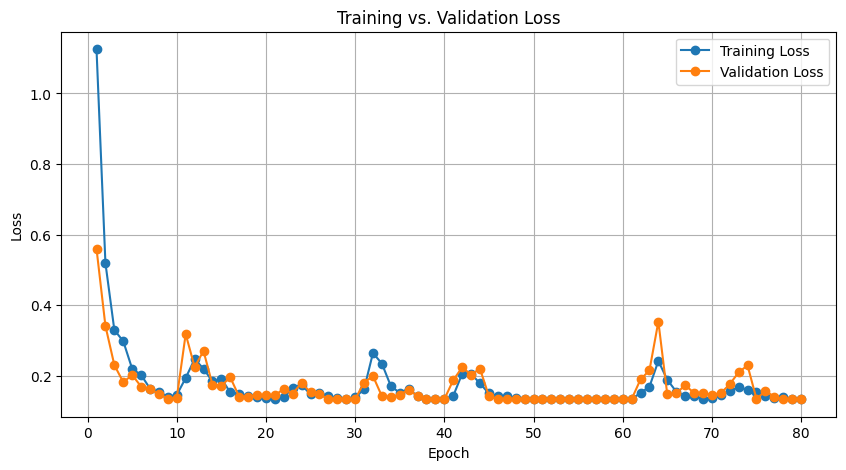

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(df['epoch'], df['train_loss'], label='Training Loss', marker='o')
plt.plot(df['epoch'], df['val_loss'], label='Validation Loss', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join("..","graphs","loss_curve.png"))
plt.show()

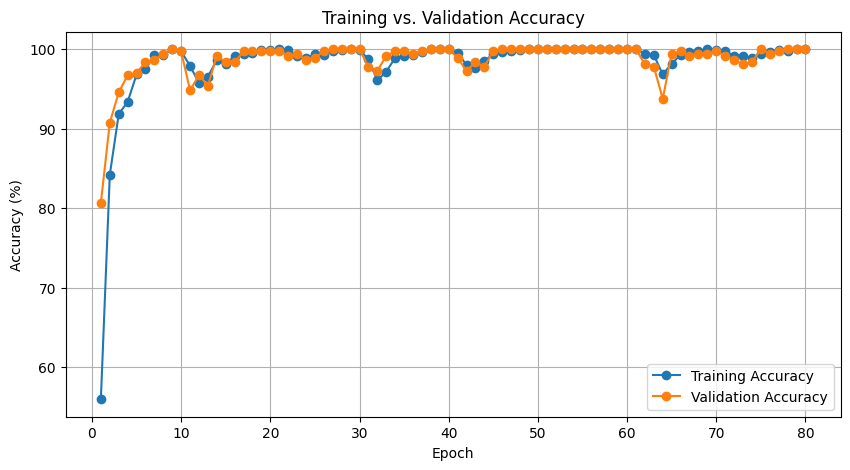

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(df['epoch'], df['train_acc'], label='Training Accuracy', marker='o')
plt.plot(df['epoch'], df['val_acc'], label='Validation Accuracy', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training vs. Validation Accuracy")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join("..","graphs","accuracy_curve.png"))
plt.show()

In [20]:
def run_real_time_prediction_v2():
    mp_holistic = mp.solutions.holistic
    mp_drawing = mp.solutions.drawing_utils
    
    # Load model and metadata
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    checkpoint = torch.load(os.path.join("..", "models", "gesture_model_enhanced_v2.pt"), 
                           map_location=device)
    
    # Get expected input size
    expected_input_size = checkpoint['input_size']
    print(f"Model expects input size: {expected_input_size}")
    
    # Create V2 model
    model = EnhancedGestureLSTMv2(
        input_size=expected_input_size,
        hidden_size=128,
        num_layers=2,
        num_classes=checkpoint['num_classes'],
        bidirectional=True
    )
    
    # Load weights
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    
    # Create label mapping
    label_map = {v: k for k, v in checkpoint['label_map'].items()}
    print(f"Loaded {len(label_map)} gesture classes: {', '.join(label_map.values())}")
    
    # Setup camera and sequence variables
    cap = cv2.VideoCapture(0)
    sequence = []
    sequence_length = 30
    prev_features = None
    
    # Prediction stabilization
    prediction_buffer = []
    buffer_size = 6  # Increase buffer size for V2
    current_prediction = None
    confidence_history = {label: [] for label in label_map.values()}
    
    with mp_holistic.Holistic(
        model_complexity=1,  # Higher complexity model
        min_detection_confidence=0.5,
        min_tracking_confidence=0.7) as holistic:
        
        while True:
            ret, frame = cap.read()
            if not ret:
                break
                
            # Mirror for intuitive interaction
            frame = cv2.flip(frame, 1)
            
            # Extract features
            features, results = extract_enhanced_keypoints(frame, holistic)
            
            # Add velocity features
            if prev_features is not None:
                velocity = features - prev_features
                features_with_vel = np.concatenate([features, velocity])
            else:
                velocity = np.zeros_like(features)
                features_with_vel = np.concatenate([features, velocity])
            
            prev_features = features
            
            # Check for hand presence
            hand_detected = (np.max(np.abs(features[:126])) > 0.05)
            
            if hand_detected:
                # Ensure correct input size
                if len(features_with_vel) < expected_input_size:
                    padding = np.zeros(expected_input_size - len(features_with_vel))
                    features_with_vel = np.concatenate([features_with_vel, padding])
                elif len(features_with_vel) > expected_input_size:
                    features_with_vel = features_with_vel[:expected_input_size]
                
                # Add to sequence
                sequence.append(features_with_vel)
                if len(sequence) > sequence_length:
                    sequence.pop(0)
                
                # Make prediction with both outputs
                if len(sequence) == sequence_length:
                    input_seq = np.array(sequence)
                    input_seq = torch.tensor(input_seq, dtype=torch.float32).unsqueeze(0).to(device)
                    
                    with torch.no_grad():
                        outputs, aux_outputs = model(input_seq)
                        
                        # Combine main and auxiliary outputs for more robust prediction
                        combined_output = outputs + 0.3 * aux_outputs
                        probabilities = torch.softmax(combined_output, dim=1)[0]
                        
                        # Get top prediction
                        predicted_idx = torch.argmax(probabilities).item()
                        confidence = probabilities[predicted_idx].item()
                        gesture_name = label_map[predicted_idx]
                        
                        # Add to buffer for stabilization
                        prediction_buffer.append((gesture_name, confidence))
                        if len(prediction_buffer) > buffer_size:
                            prediction_buffer.pop(0)
                        
                        # Count occurrences and confidences
                        gesture_counts = {}
                        total_conf = {}
                        for g, c in prediction_buffer:
                            gesture_counts[g] = gesture_counts.get(g, 0) + 1
                            total_conf[g] = total_conf.get(g, 0) + c
                        
                        # Find most common gesture with good confidence
                        if gesture_counts:
                            # Use weighted combination of count and confidence
                            gesture_scores = {
                                g: 0.7 * (count / len(prediction_buffer)) + 
                                   0.3 * (total_conf[g] / count)
                                for g, count in gesture_counts.items()
                            }
                            
                            stable_gesture = max(gesture_scores.items(), key=lambda x: x[1])[0]
                            avg_confidence = total_conf[stable_gesture] / gesture_counts[stable_gesture]
                            
                            # Update confidence history
                            confidence_history[stable_gesture].append(avg_confidence)
                            if len(confidence_history[stable_gesture]) > 10:
                                confidence_history[stable_gesture].pop(0)
                                
                            # Only update if we have a stable prediction
                            min_buffer_ratio = 0.5  # At least half the buffer should agree
                            if gesture_counts[stable_gesture] >= buffer_size * min_buffer_ratio:
                                current_prediction = stable_gesture
                                current_confidence = np.mean(confidence_history[stable_gesture])
                            
                    # Display prediction with confidence
                                cv2.putText(frame, f"{current_prediction} ({current_confidence:.2f})",
                                (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
                    
            
            # Display UI elements
            # (UI code remains similar to previous version)
            # Draw landmarks
            if results.right_hand_landmarks:
                mp_drawing.draw_landmarks(frame, results.right_hand_landmarks, 
                                         mp_holistic.HAND_CONNECTIONS)
            if results.left_hand_landmarks:
                mp_drawing.draw_landmarks(frame, results.left_hand_landmarks, 
                                         mp_holistic.HAND_CONNECTIONS)
            if results.face_landmarks:
                mp_drawing.draw_landmarks(frame, results.face_landmarks, 
                                         mp_holistic.FACEMESH_CONTOURS,
                                         landmark_drawing_spec=None)
            
            cv2.imshow('Enhanced ISL Recognition V2', frame)
            if cv2.waitKey(5) & 0xFF == 27:
                break
                
    cap.release()
    cv2.destroyAllWindows()

In [21]:
run_real_time_prediction_v2()

Model expects input size: 342
Loaded 7 gesture classes: bye, hello, namaste, practice, sorry, thankyou, welcome
